# Preamble

In [297]:
import os
import sys
import json, pickle
import warnings
import operator
import random

import numpy as np
import scipy
import pandas as pd

import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import seaborn as sns

import lifelines as ll
from sksurv.ensemble import RandomSurvivalForest

from sklearn.model_selection import StratifiedGroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc

import shap

## File Loading

In [2]:
toh_data_file_path = "../data/complete_merged_fixes.xlsx"

definitions_file_path = "../data/config/definitions.json"

df_toh_master = pd.read_excel(toh_data_file_path, sheet_name=None)["COMPLETE_FIXES"]

# handy-dandy glossary for column lookup
hdg = {}
with open(definitions_file_path, "r", encoding="utf-8") as file:
    hdg = json.load(file)

## Global Config

In [3]:
# wow very nice, Jupyter
module_path = os.path.abspath(os.path.join("C:\\Users\\mmk\\PycharmProjects\\ckd"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# put %autoreload at the start of every cell using ckdlib attributes
%load_ext autoreload

%aimport ckdlib.formulae
flib = ckdlib.formulae

%aimport ckdlib.my_seaborn_plots
plib = ckdlib.my_seaborn_plots

%aimport ckdlib.utils
ulib = ckdlib.utils

%aimport ckdlib.defs
defs = ckdlib.defs

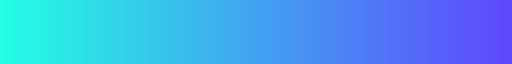

In [5]:
my_colors = ["#24FFE5", "#6047FF"]

my_cmap = sns.blend_palette(colors=my_colors, n_colors=3, as_cmap=True)
my_cmap

In [6]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Functions

## Experiment Loop

In [7]:
def specialized_cv_loop(data, labeltype, ttetype, var_set: set, folds=None, t_indexer=12 * 30) -> dict:
    """Things I want:
        A list of missed patients (outright; no caught visits).
        For each patient:
            Length of observation period.
                > Num follow ups.
                > Time to event at visit 0.
            Time of first detection (tte of the first positively predicted visit).
                > Array of probability predictions.
            Consistency of predictions therafter; 
                > Array of labels.
                > Array of time-to-events.
            SHAP Values from the model of that fold, computed on the held out patients
                > I believe this becomes a matrix, with the per feature contribution to the predicted score.
                    > So each patient gets a dict entry with a v x f x 1, where v is the number of visits for 
                        that patient, f is the number of features, 1 is the SHAP Value towards the positive
                        class (need to slice those out I think).
    """

    out_dict = dict()

    if folds is None:
        sgkf_toh = StratifiedGroupKFold(n_splits=5)
        folds = [f for f in sgkf_toh.split(data, data[labeltype], groups=data.pt_id)]


    for current_fold, (train_i, test_i) in enumerate(folds):
        x_train = data.reset_index(drop=True).loc[train_i]
        y_train = data.reset_index(drop=True)[labeltype].loc[train_i]
        x_test = data.reset_index(drop=True).loc[test_i]
        y_test = data.reset_index(drop=True)[labeltype].loc[test_i]

        classes_weights = {
            0: len(y_train) / (2 * y_train.value_counts()[0]), 
            1: len(y_train) / (2 * y_train.value_counts()[1])
        }

        # RF
        model = RandomForestClassifier(
            max_depth=16, min_samples_leaf=8, min_samples_split=4, oob_score=True, n_estimators=500, class_weight=classes_weights, n_jobs=-1
        )
        model = model.fit(x_train[[*var_set]], y_train)

        # explainer = shap.TreeExplainer(model)

        ####### COX START #######
        # ~~~~~ SETUP ~~~~~ #
        # individuals baseline
        inds_b = x_train.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)

        data_b = inds_b[var_set].copy()
        means_b = data_b[var_set].mean()
        data_b[var_set] -= means_b

        data_b = pd.concat([data_b, inds_b[["censordial", "sa_time"]]], axis=1)
        data_b["censordial"] = (data_b.censordial == 0).astype(int)

        # time-varying
        data_tv = x_train[var_set].copy()
        means_tv = data_tv[var_set].mean()
        data_tv[var_set] -= means_tv

        data_tv = pd.concat([data_tv, x_train[["pt_id", "start", "stop", "event"]]], axis=1)

        # don't center categoricals like gender
        for v in var_set:
            if v in defs.cat_voi:
                data_b[v] = inds_b[v].copy()
                data_tv[v] = x_train[v].copy()

        cph_b, cph_tv = ulib.dumb_code_greyout_fix(data_b, data_tv) # calls to lifelines.CoxPHFitter grey out any code under

        # building equation
        beta_b = cph_b.params_.ravel()        
        S0t_b = cph_b.baseline_survival_

        # parameters and stuff
        beta_tv = cph_tv.params_.ravel()
        H0t_tv = cph_tv.baseline_cumulative_hazard_

        rsf = RandomSurvivalForest(
            max_depth=16, min_samples_leaf=8, min_samples_split=4, oob_score=True, n_estimators=500
        )
        # make format for sksurv (list of tuples: (censor, sa_time))
        inds_rsf = x_train.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)
        x_rsf = inds_rsf[var_set].copy()
        y_rsf = ulib.format_for_sksurv(inds_rsf[["censordial", "sa_time"]])

        rsf.fit(x_rsf, y_rsf)
        rsf_index = rsf.event_times_


        for pt in set(x_test.pt_id):
            patient_df = x_test.loc[x_test.pt_id == pt].copy()
            
            # RCF PROBS
            patient_probs = model.predict_proba(patient_df[[*var_set]]).round(6)[:,1]

            # shap_values = explainer.shap_values(patient_df[[*var_set]])

            n_fups = patient_df.shape[0]
            labels, ttes = patient_df[labeltype].to_numpy(), patient_df[ttetype].to_numpy()

            # need to center predictors
            test_b = patient_df[var_set] - means_b
            test_tv = patient_df[var_set] - means_tv

            # don't center categoricals like gender
            for v in var_set:
                if v in defs.cat_voi:
                    test_b[v] = x_test[v].copy()
                    test_tv[v] = x_test[v].copy()

            # BL COX PROBS
            ris_b = np.exp(np.apply_along_axis(np.dot, 1, test_b[cph_b.params_.index], beta_b))
            Sts_b = np.apply_along_axis(np.power, 1, S0t_b, ris_b)

            probs_b_bl = np.empty(shape=patient_df.shape[0], dtype=np.float64)

            for ttei, tte in enumerate(ttes): # just baseline visit
                tfbl = (ttes.max() - tte) + (t_indexer) # at t_indexer month offsets

                St_b = Sts_b[:,0] # 0

                if tfbl in set(S0t_b.index):
                    prob = pd.DataFrame(St_b, index=S0t_b.index).loc[tfbl].to_numpy()[0]
                    probs_b_bl[ttei] = 1 - prob
                else:
                    probs_b_bl[ttei] = 1 - St_b[abs((S0t_b.index - tfbl).to_numpy()).argsort()[:2]].mean()

            # REAPPLYING BL COX AT EACH VISIT
            probs_b_bl2 = np.empty(shape=patient_df.shape[0], dtype=np.float64)

            for i in range(len(test_b)):
                St_b = Sts_b[:,i]

                if t_indexer in set(S0t_b.index):                        
                    prob = pd.DataFrame(St_b, index=S0t_b.index).loc[t_indexer].to_numpy()[0]
                    probs_b_bl2[i] = 1 - prob
                else:
                    probs_b_bl2[i] = 1 - St_b[abs((S0t_b.index - t_indexer).to_numpy()).argsort()[:2]].mean()


            # TV COX PROBS
            ris_tv = np.exp(np.apply_along_axis(np.dot, 1, test_tv[cph_tv.params_.index], beta_tv))

            probs_tv_pv = np.empty(shape=patient_df.shape[0])

            for ttei, tte in enumerate(ttes): # per visit
                # P_i(t, t + h) = e^[-{H0(t + h) - H0(t)} * r_i(t)] (Altman and De Stavola)
                # here h, will be t_indexer, or the timeframe we wish to predict over
                # so for each visit, we are obtaining the probability of survival through the next 6, 12, 24 months,
                #   conditional on survival to the time of current visit
                rit = ris_tv[ttei]
                tfbl = (ttes.max() - tte) + (t_indexer) # at t_indexer month offsets (<12> months out from current visit)


                # first we want H0 at time of current visit
                if tfbl - t_indexer in set(H0t_tv.index):
                    H0t = pd.DataFrame(H0t_tv, index=H0t_tv.index).loc[tfbl - t_indexer].to_numpy()[0]
                else:
                    H0t = H0t_tv.iloc[abs((H0t_tv.index - (tfbl - t_indexer)).to_numpy()).argsort()[:2]].mean().to_numpy()[0]

                # now we want H0th
                if tfbl in set(H0t_tv.index):
                    H0th = pd.DataFrame(H0t_tv, index=H0t_tv.index).loc[tfbl].to_numpy()[0]
                else:
                    H0th = H0t_tv.iloc[abs((H0t_tv.index - tfbl).to_numpy()).argsort()[:2]].mean().to_numpy()[0]

                probs_tv_pv[ttei] = 1 - np.exp(-(H0th - H0t) * rit)

            # RSF PROBS
            test_rsf = patient_df[var_set].copy()
            probs_rsf_bl = np.empty(shape=patient_df.shape[0])

            rsf_survs = rsf.predict_survival_function(test_rsf, return_array=True)

            for ttei, tte in enumerate(ttes): # just baseline visit
                tfbl = (ttes.max() - tte) + (t_indexer) # at t_indexer month offsets

                St_rsf = rsf_survs[0]

                if tfbl in set(rsf_index):
                    prob = pd.DataFrame(St_rsf, index=rsf_index).loc[tfbl].to_numpy()[0]
                    probs_rsf_bl[ttei] = 1 - prob
                else:
                    probs_rsf_bl[ttei] = 1 - St_rsf[abs(rsf_index - tfbl).argsort()[:2]].mean()

            # PROBS RSF TYPE 2 (REAPPLYING AT EACH VISIT)
            probs_rsf_bl2 = np.empty(shape=patient_df.shape[0])
            for i in range(len(test_rsf)):
                St_rsf = rsf_survs[i]

                if t_indexer in set(rsf_index):
                    prob = pd.DataFrame(St_rsf, index=rsf_index).loc[t_indexer].to_numpy()[0]
                    probs_rsf_bl2[i] = 1 - prob
                else:
                    probs_rsf_bl2[i] = 1 - St_rsf[abs(rsf_index - t_indexer).argsort()[:2]].mean()


            out_dict[pt] = {
                "# Follow-Ups": n_fups,
                "Had Event": (labels.sum() > 0).astype(int),
                "Time Until End": ttes,
                "Label": labels,
                "Fold": current_fold,
                "Model Predictions": {
                    "RCF": {
                        "P(KF)": patient_probs
                    },
                    "BL COX": {
                        "P(KF)": probs_b_bl,        # probability obtained from accessing the adjusted survivor curve (from baseline visit), at each subsequent time of visit
                        "P2(KF)": probs_b_bl2,
                        "BETAS": beta_b,                    # log-HRs of Cox model fitted on folds F = {f | f != current_fold}
                        "SE": cph_b.standard_errors_
                    },
                    "TV COX": {
                        "P(KF)": probs_tv_pv,           # probability obtained using conditional probability equation (Altman and De Stavola)
                        "BETAS": beta_tv,                   # log-HRs of Cox model fitted on folds F = {f | f != current_fold}
                        "SE": cph_tv.standard_errors_
                    },
                    "RSF": {
                        "P(KF)": probs_rsf_bl, 
                        "P2(KF)": probs_rsf_bl2
                    } 
                }
            }

    return out_dict

## Figure 3 Panel

In [478]:
def make_panel(d, prre):
    plt.style.use("default")
    g = sns.catplot(
        x="Timeframe (Months)", y="Metric Value", hue="Name", col="Metric", col_wrap=3,
        data=d.loc[(d.Metric == "AUC-ROC") | (d.Metric == prre)], kind="point", 
        errorbar=("ci", 0.95), dodge=0.6, aspect=1, palette=["#070706", "#8377D1", "#5B869E", "#975061", "#6EB6AD", "#47568F"], 
        
        sharey=True, sharex=False,
        col_order=["AUC-ROC", prre],
        hue_order=[
            "Cox Baseline", "Cox Time-Varying", 
            "Random Survival Forest", "Random Forest Classifier"
        ],
        markers=["_", "_", "_", "_"], scale=1.5, errwidth=2, join=False, capsize=0.00,
        legend=False, facet_kws={}, **{"sym":""}
    )

    # 0 -------------------
    g.axes[0].hlines(
        y=[0.6, 0.7, 0.8, 0.9], xmin=-0.25, xmax=2.25, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    g.axes[0].legend(loc="upper center", bbox_to_anchor=(0.52, 1.12), title="AUC-ROC", title_fontproperties=dict(weight="bold", size="12"), 
                     ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.1, borderpad=0.2, handletextpad=0.0, edgecolor="black",
                     fontsize="large")

    leg2 = Legend(g.axes[0], [], [], loc="upper center", bbox_to_anchor=(0, 1.13), title="A", title_fontproperties=dict(weight="bold", size="24"), 
                  ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    g.axes[0].add_artist(leg2)

    g.despine(right=False, top=False)
    g.axes[0].set_title("")
    g.axes[0].set_ylabel("Cross-Validation Mean [95% CI]", fontdict=dict(fontweight="bold", size="x-large"))
    g.axes[0].set_xlabel("Timeframe (Months)", fontdict=dict(fontweight="bold", size="x-large"))
    g.axes[0].set_ylim((0.5, 1))
    g.axes[0].tick_params(axis="y", labelsize=14)
    g.axes[0].tick_params(axis="x", labelsize=14)


    # 1 -------------------
    g.axes[1].hlines(
        y=[0.6, 0.7, 0.8, 0.9], xmin=-0.25, xmax=2.25, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    g.axes[1].legend(loc="upper center", bbox_to_anchor=(0.52, 1.12), title="PrRe70", title_fontproperties=dict(weight="bold", size="12"), 
                     ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.1, borderpad=0.2, handletextpad=0.0, edgecolor="black",
                     fontsize="large")

    leg2 = Legend(g.axes[1], [], [], loc="upper center", bbox_to_anchor=(0, 1.13), title="B", title_fontproperties=dict(weight="bold", size="24"), 
                  ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    g.axes[1].add_artist(leg2)

    g.despine(right=False, top=False)
    g.axes[1].set_title("")
    g.axes[1].set_xlabel("Timeframe (Months)", fontdict=dict(fontweight="bold", size="x-large"))
    g.axes[1].set_ylim((0.5, 1))
    g.axes[1].tick_params(axis="x", labelsize=14)

    plt.tight_layout()
    plt.show()

## Figure 4 Panel

In [485]:
def joined_scat_plot(in_dict, event_int, model_name, deep_key, pt_samps_to_plot=list(), pt_samps_for_lois=list(), title="TITLE", letter="A", xlabel=True, ylabel=True, ax=None):

    if len(pt_samps_to_plot) > 2:
        print("ONLY HANDLES 2 STRATIFICATIONS FOR NOW")
        return

    if ax is None:
        fig, plot = plt.subplots(1, 1)
        fig.set_size_inches(12, 5.5)
    else:
        plot = ax

    # markers = ["o", "v", "^", "h", "*", "X", "8", "s", "p", "P"]
    markers = ["o" for _ in range(len(pt_samps_to_plot[0]))]

    plot.add_patch(
        mpl.patches.Rectangle((0, 50), 12, 50, edgecolor=None, facecolor="goldenrod", fill=True, alpha=0.5)
    )
    plot.add_patch(
        mpl.patches.Rectangle((0, 50), 12, 50, edgecolor="goldenrod", fill=False, alpha=1, lw=5)
    )

    for pt_sampi, pt_samp in enumerate(pt_samps_to_plot):
        labs = ulib.get_common_key_values(
            in_dict, "Label", sort=True, cond_lkey="Had Event", cond_op=operator.eq, cond_rvalue=event_int,
            key_set=pt_samp
        )
        preds = ulib.get_common_key_values(
            in_dict, "Model Predictions", sort=True, cond_lkey="Had Event", cond_op=operator.eq, cond_rvalue=event_int,
            deep_key=model_name, deep_deep_key=deep_key,
            key_set=pt_samp
        )
        preds_for_lois = ulib.get_common_key_values(
            in_dict, "Model Predictions", sort=True, cond_lkey="Had Event", cond_op=operator.eq, cond_rvalue=event_int,
            deep_key=model_name, deep_deep_key=deep_key,
            key_set=pt_samps_for_lois[pt_sampi]
        )

        ttes, ttes_for_lois = list(), list()
        
        for pt in sorted(pt_samp):
            if in_dict[pt]["Had Event"] == event_int:
                ttes.append(in_dict[pt]["Time Until End"])

        for pt in sorted(pt_samps_for_lois[pt_sampi]):
            if in_dict[pt]["Had Event"] == event_int:
                ttes_for_lois.append(in_dict[pt]["Time Until End"])


        for pti, pt in enumerate(preds):
            smoothed_preds = preds[pti]
            pt_labs = labs[pti]
            cut_ttes = (ttes[pti] / 30)

            plot.plot(cut_ttes, smoothed_preds * 100, c="black", alpha=0.15, marker=markers[pti])
            plot.scatter(cut_ttes, smoothed_preds * 100, c=my_colors[pt_sampi], alpha=0.55, marker=markers[pti])

        plot.axhline(50, c="gray", linestyle="dashed")
        plot.set_xlim(60, 0)
        plot.set_ylim(0, 100)

        if ylabel:
            plot.set_ylabel("Predicted Risk of Kidney Failure (%)", fontdict=dict(weight="bold", size="x-large"))
            plot.tick_params(axis="y", labelsize=14)
        if xlabel:
            plot.set_xlabel("Months Until Kidney Failure", fontdict=dict(weight="bold", size="x-large"))
            plot.tick_params(axis="x", labelsize=14)

        
        lowess = sm.nonparametric.lowess(ulib.flatten_jagged(preds_for_lois) * 100, ulib.flatten_jagged(ttes_for_lois) / 30, frac=0.50, is_sorted=False)
        plot.plot(lowess[:, 0], lowess[:, 1], color=my_colors[pt_sampi], linewidth=4)

    legend_elements = [
        # mpl.lines.Line2D([0], [0], marker="o", color="white", label="", markersize=0),
        # mpl.patches.Patch(edgecolor=my_colors[0], facecolor=my_colors[0], label=" AUC-ROC {:.2f}".format(mets.ravel()[0])),
        mpl.lines.Line2D([0], [0], marker="o", color=my_colors[1], label=" Planned Dialysis Patients", markersize=5),
        # mpl.patches.Patch(edgecolor=my_colors[0], facecolor=my_colors[0], label=" AUC-PR {:.2f}".format(mets.ravel()[1])),
        mpl.lines.Line2D([0], [0], marker="o", color=my_colors[0], label=" Unplanned Dialysis Patients", markersize=5),
        mpl.patches.Patch(edgecolor="goldenrod", facecolor="goldenrod", label=" True Positive Region"),
        # mpl.lines.Line2D([0], [0], marker="o", color="white", label="", markersize=0),
        # mpl.patches.Patch(edgecolor=my_colors[0], facecolor=my_colors[0], label=" Brier {:.2f}".format(mets.ravel()[3]))
    ]

    leg1 = Legend(
        plot, handles=legend_elements, labels=[
            " Planned Dialysis Patients", " Unplanned Dialysis Patients", " True Positive Region"
        ],
        loc="upper center", bbox_to_anchor=(0.50, 1.11), title=title, title_fontproperties=dict(weight="bold", size="12"), 
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.1, borderpad=0.2, handletextpad=0.0, edgecolor="black",
        fontsize="large"
    )
    plot.add_artist(leg1)

    leg2 = Legend(plot, [], [], loc="upper center", bbox_to_anchor=(0, 1.12), title=letter, title_fontproperties=dict(weight="bold", size="24"), 
                  ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plot.add_artist(leg2)

# Setup

In [9]:
%autoreload

vs = [
    ["spot_acr", "age", "egfr", "gender"],
    ["spot_acr", "age", "egfr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "spot_acr", "age", "egfr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "spot_acr", "age", "egfr", "gender", "alb", "phos", "calc", "total_co2", "potassium", "pmh_chf", "measd_sbp"]
]

dfs = ulib.preamble_ndt(df_toh_master, var_set=vs[-1], timeframes=[6, 12, 24], chop_easy=False, chop_end=False)

VARIABLES:  ['diabetes', 'pmh_hyper', 'spot_acr', 'age', 'egfr', 'gender', 'alb', 'phos', 'calc', 'total_co2', 'potassium', 'pmh_chf', 'measd_sbp']
~~~6~~~
0    12820
1     2026
2      873
3      581
Name: labelo, dtype: int64
0    13401
1     2899
Name: labeldial, dtype: int64
2432
~~~12~~~
0    10398
1     3328
2     1417
3     1157
Name: labelo, dtype: int64
0    11555
1     4745
Name: labeldial, dtype: int64
2432
~~~24~~~
0    7396
1    4858
2    2105
3    1941
Name: labelo, dtype: int64
0    9337
1    6963
Name: labeldial, dtype: int64
2432
0    14270
1     2030
Name: ex, dtype: int64
TRUNCATIONS: 
0    11779
1     2053
Name: truncdial, dtype: int64
0    14270
1     2030
Name: ex, dtype: int64
TRUNCATIONS: 
0    12069
1     1763
Name: truncdial, dtype: int64
0    14270
1     2030
Name: ex, dtype: int64
TRUNCATIONS: 
0    12249
1     1583
Name: truncdial, dtype: int64


In [10]:
labelnames = ["labeldial6", "labeldial12", "labeldial24"]
labeltimes = [6, 12, 24]
ttetype = "tteo"

df = dfs[24].copy()
df["labeldial6"] = dfs[6].labeldial
df["labeldial12"] = dfs[12].labeldial
df["labeldial24"] = df.labeldial

# dropping visits (and potentially patients) with no event (dialysis or death) and less than 24 months of FUP
df = df.loc[df.truncdial == 0].reset_index()

print(df.shape)
print(df[labelnames].sum())

(11793, 64)
labeldial6     2562
labeldial12    4265
labeldial24    6330
dtype: int64


In [278]:
%autoreload

results_by_time = list()

for labeltime, labelname in zip(labeltimes, labelnames):
    sgkf = StratifiedGroupKFold(n_splits=5)
    folds = [f for f in sgkf.split(df, df[labelname], groups=df.pt_id)]

    results_by_v = list()

    for var_set in vs:
        results_by_v.append(specialized_cv_loop(df, labelname, ttetype, var_set, folds=folds, t_indexer=labeltime * 30))

    results_by_time.append(results_by_v)

In [279]:
for timei, time in enumerate(results_by_time):
    for vari, var in enumerate(time):
        pickle.dump(var, open("../out/results/pt_results_t{}_vs{}_{}.p".format(labeltimes[timei], vari, ulib.get_time_now_str("dmy")), "wb"))

# Results

In [11]:
results_by_time = list()

# optionally load
for timei in range(3):
    temp = list()

    for vari in range(4):
        temp.append(pickle.load(open("../out/results/pt_results_t{}_vs{}_17-11-2022.p".format(labeltimes[timei], vari), "rb")))

    results_by_time.append(temp)

In [65]:
model_dict = dict()
convenience_dict = {"BL COX": dict(), "BL COX2": dict(), "TV COX": dict(), "RSF": dict(), "RSF2": dict(), "RCF": dict()}
metrics = ["AUC-ROC", "AUC-PR", "PrRe70", "Brier"]

for model in ("BL COX", "TV COX", "RSF", "RCF"):

    per_timeframe_in_var_group_vals = None
    per_timeframe_in_var_group_stds = None

    for timeframei, timegroup in enumerate(results_by_time):
        
        perf_per_var_group_vals = list()
        perf_per_var_group_stds = list()
    
        for var_groupi, var_group in enumerate(timegroup):
            fold_perfs = list()

            for foldi in range(5):
                flatlabs = ulib.flatten_jagged(ulib.get_common_key_values(var_group, "Label", sort=True, cond_lkey="Fold", cond_op=operator.eq, cond_rvalue=foldi))
                flatpreds = ulib.flatten_jagged(ulib.get_common_key_values(
                    var_group, "Model Predictions", sort=True, cond_lkey="Fold", cond_op=operator.eq, cond_rvalue=foldi, 
                    deep_key=model, deep_deep_key="P(KF)" if model != "BL COX" and model != "RSF" else "P2(KF)")
                )
                fold_perfs.append(ulib.get_metrics(flatlabs, flatpreds))

            to_add = pd.DataFrame(fold_perfs)
            perf_per_var_group_vals.append(to_add.mean().to_numpy())
            perf_per_var_group_stds.append([ulib.stringify_bootstrap_ci(scipy.stats.bootstrap((to_add[col].to_numpy(), ), np.mean, method="percentile")) for col in metrics])

            convenience_dict[model]["{}{}".format(timeframei, var_groupi)] = to_add

            if model == "BL COX" or model == "RSF":
                fold_perfs = list()

                for foldi in range(5):
                    flatlabs = ulib.flatten_jagged(ulib.get_common_key_values(var_group, "Label", sort=True, cond_lkey="Fold", cond_op=operator.eq, cond_rvalue=foldi))
                    flatpreds = ulib.flatten_jagged(ulib.get_common_key_values(
                        var_group, "Model Predictions", sort=True, cond_lkey="Fold", cond_op=operator.eq, cond_rvalue=foldi, 
                        deep_key=model, deep_deep_key="P(KF)")
                    )
                    fold_perfs.append(ulib.get_metrics(flatlabs, flatpreds))

                to_add = pd.DataFrame(fold_perfs)
                # perf_per_var_group_vals.append(to_add.mean().to_numpy())
                # perf_per_var_group_stds.append(to_add.std().to_numpy() * 1.96)

                convenience_dict[model + "2"]["{}{}".format(timeframei, var_groupi)] = to_add

        per_timeframe_in_var_group_vals = pd.concat([per_timeframe_in_var_group_vals, pd.DataFrame(np.stack(perf_per_var_group_vals))], axis=1)
        per_timeframe_in_var_group_stds = pd.concat([per_timeframe_in_var_group_stds, pd.DataFrame(np.stack(perf_per_var_group_stds))], axis=1)

    model_dict[model] = per_timeframe_in_var_group_vals.round(2).astype(str) + " " + per_timeframe_in_var_group_stds.round(2).astype(str)

## Table 2

In [66]:
final_tab2 = None

for model in ("BL COX", "TV COX", "RSF", "RCF"):
    final_tab2 = pd.concat([final_tab2, model_dict[model]])

final_tab2

,0,1,2,3,0,1,2,3,0,1,2,3
0,"0.85 (0.84, 0.86)","0.62 (0.59, 0.64)","0.53 (0.51, 0.55)","0.14 (0.14, 0.14)","0.85 (0.84, 0.87)","0.77 (0.74, 0.79)","0.71 (0.68, 0.72)","0.17 (0.16, 0.17)","0.85 (0.83, 0.87)","0.86 (0.84, 0.89)","0.83 (0.8, 0.85)","0.16 (0.16, 0.17)"
1,"0.85 (0.84, 0.86)","0.62 (0.59, 0.64)","0.53 (0.5, 0.55)","0.14 (0.14, 0.14)","0.85 (0.84, 0.86)","0.76 (0.74, 0.78)","0.7 (0.67, 0.72)","0.17 (0.16, 0.17)","0.85 (0.83, 0.86)","0.86 (0.83, 0.88)","0.83 (0.81, 0.85)","0.16 (0.16, 0.17)"
2,"0.85 (0.84, 0.86)","0.62 (0.6, 0.64)","0.52 (0.5, 0.55)","0.13 (0.12, 0.13)","0.85 (0.83, 0.86)","0.76 (0.75, 0.78)","0.7 (0.68, 0.72)","0.15 (0.15, 0.16)","0.85 (0.83, 0.86)","0.86 (0.84, 0.88)","0.83 (0.81, 0.85)","0.17 (0.16, 0.18)"
3,"0.85 (0.84, 0.86)","0.63 (0.6, 0.65)","0.52 (0.5, 0.54)","0.13 (0.12, 0.13)","0.85 (0.84, 0.86)","0.76 (0.75, 0.78)","0.69 (0.67, 0.71)","0.15 (0.15, 0.16)","0.85 (0.83, 0.86)","0.86 (0.84, 0.88)","0.83 (0.8, 0.85)","0.17 (0.16, 0.18)"
0,"0.88 (0.87, 0.89)","0.7 (0.67, 0.73)","0.62 (0.6, 0.64)","0.11 (0.11, 0.11)","0.86 (0.84, 0.87)","0.79 (0.76, 0.81)","0.73 (0.68, 0.77)","0.16 (0.15, 0.17)","0.83 (0.81, 0.84)","0.85 (0.83, 0.86)","0.81 (0.79, 0.83)","0.22 (0.21, 0.22)"
1,"0.88 (0.87, 0.89)","0.7 (0.67, 0.73)","0.62 (0.59, 0.65)","0.11 (0.1, 0.11)","0.86 (0.84, 0.88)","0.79 (0.75, 0.82)","0.73 (0.69, 0.77)","0.16 (0.15, 0.17)","0.83 (0.82, 0.84)","0.85 (0.83, 0.86)","0.81 (0.79, 0.83)","0.21 (0.21, 0.22)"
2,"0.88 (0.87, 0.89)","0.7 (0.68, 0.73)","0.62 (0.59, 0.64)","0.1 (0.1, 0.11)","0.86 (0.84, 0.88)","0.79 (0.75, 0.82)","0.73 (0.69, 0.78)","0.15 (0.14, 0.16)","0.83 (0.81, 0.84)","0.85 (0.83, 0.86)","0.81 (0.79, 0.83)","0.2 (0.19, 0.21)"
3,"0.88 (0.87, 0.89)","0.71 (0.68, 0.73)","0.61 (0.58, 0.65)","0.1 (0.1, 0.11)","0.86 (0.84, 0.88)","0.79 (0.76, 0.81)","0.73 (0.69, 0.77)","0.15 (0.14, 0.16)","0.83 (0.81, 0.84)","0.85 (0.83, 0.86)","0.81 (0.79, 0.83)","0.19 (0.19, 0.21)"
0,"0.87 (0.86, 0.88)","0.68 (0.65, 0.72)","0.61 (0.57, 0.64)","0.11 (0.11, 0.12)","0.86 (0.84, 0.88)","0.79 (0.77, 0.8)","0.73 (0.69, 0.76)","0.14 (0.14, 0.15)","0.85 (0.83, 0.86)","0.87 (0.85, 0.88)","0.82 (0.8, 0.85)","0.16 (0.15, 0.17)"
1,"0.88 (0.87, 0.89)","0.69 (0.65, 0.72)","0.61 (0.58, 0.63)","0.12 (0.12, 0.12)","0.87 (0.85, 0.88)","0.79 (0.77, 0.81)","0.74 (0.7, 0.77)","0.15 (0.14, 0.15)","0.85 (0.83, 0.87)","0.87 (0.85, 0.88)","0.83 (0.81, 0.85)","0.16 (0.15, 0.17)"


## Figure 3

In [320]:
# best prres above are 
# BL: (0) 4, (0) 4, (2) 10
# TV: (0) 4, (2) 10, (3) 13
# RSF: (0) 4, (1) 8, (2) 10
# RCF: (2) 10, (1) 8, (3) 13
bests_dict = {
    "BL COX": {0:0, 1:0, 2:2},
    "BL COX2": {0:0, 1:0, 2:2},
    "TV COX": {0:0, 1:2, 2:3},
    "RSF": {0:0, 1:1, 2:2},
    "RSF2": {0:0, 1:1, 2:2},
    "RCF": {0:2, 1:1, 2:3}
}
names_dict = {
    "BL COX": "Cox Baseline",
    "TV COX": "Cox Time-Varying",
    "RSF": "Random Survival Forest",
    "RCF": "Random Forest Classifier"
}

In [321]:
for_fig = None

for ti, t in enumerate(labeltimes):
    for model in ("BL COX", "TV COX", "RSF", "RCF"):
        to_add = convenience_dict[model]["{}{}".format(ti, bests_dict[model][ti])].copy()
        to_add[3] = t
        to_add["Name"] = names_dict[model]
        for_fig = pd.concat([for_fig, to_add], axis=0)

for_fig.columns = ["AUC-ROC", "AUC-PR", "PrRe70", "Brier", "Timeframe (Months)", "Name"]

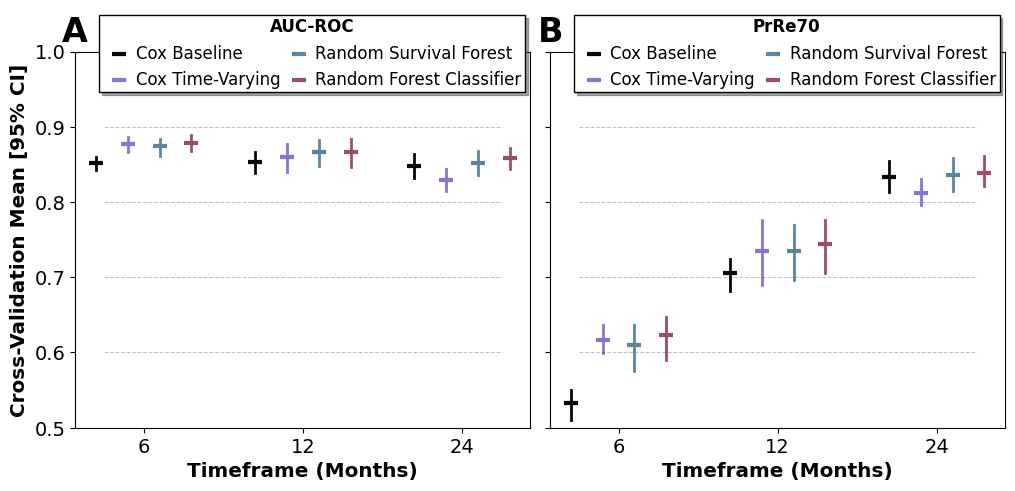

<Figure size 640x480 with 0 Axes>

In [479]:
make_panel(pd.melt(for_fig, id_vars=["Name", "Timeframe (Months)"], var_name="Metric", value_name="Metric Value"), "PrRe70")
plt.tight_layout(h_pad=3.5)

## Figure 4

In [86]:
ud_sample = set()
pd_sample = set()
ne_sample = set()
d_sample = set()

for pt in results_by_time[1][1].keys():
    if ulib.get_pt_category(df, pt) == "UD":
        ud_sample.add(pt)
    elif ulib.get_pt_category(df, pt) == "PD":
        pd_sample.add(pt)
    elif ulib.get_pt_category(df, pt) == "No Event":
        ne_sample.add(pt)
    elif ulib.get_pt_category(df, pt) == "Death":
        d_sample.add(pt)

### Sampling

In [345]:
samp1, samp2 = set(random.sample(ud_sample, 10)), set(random.sample(pd_sample, 10))

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.


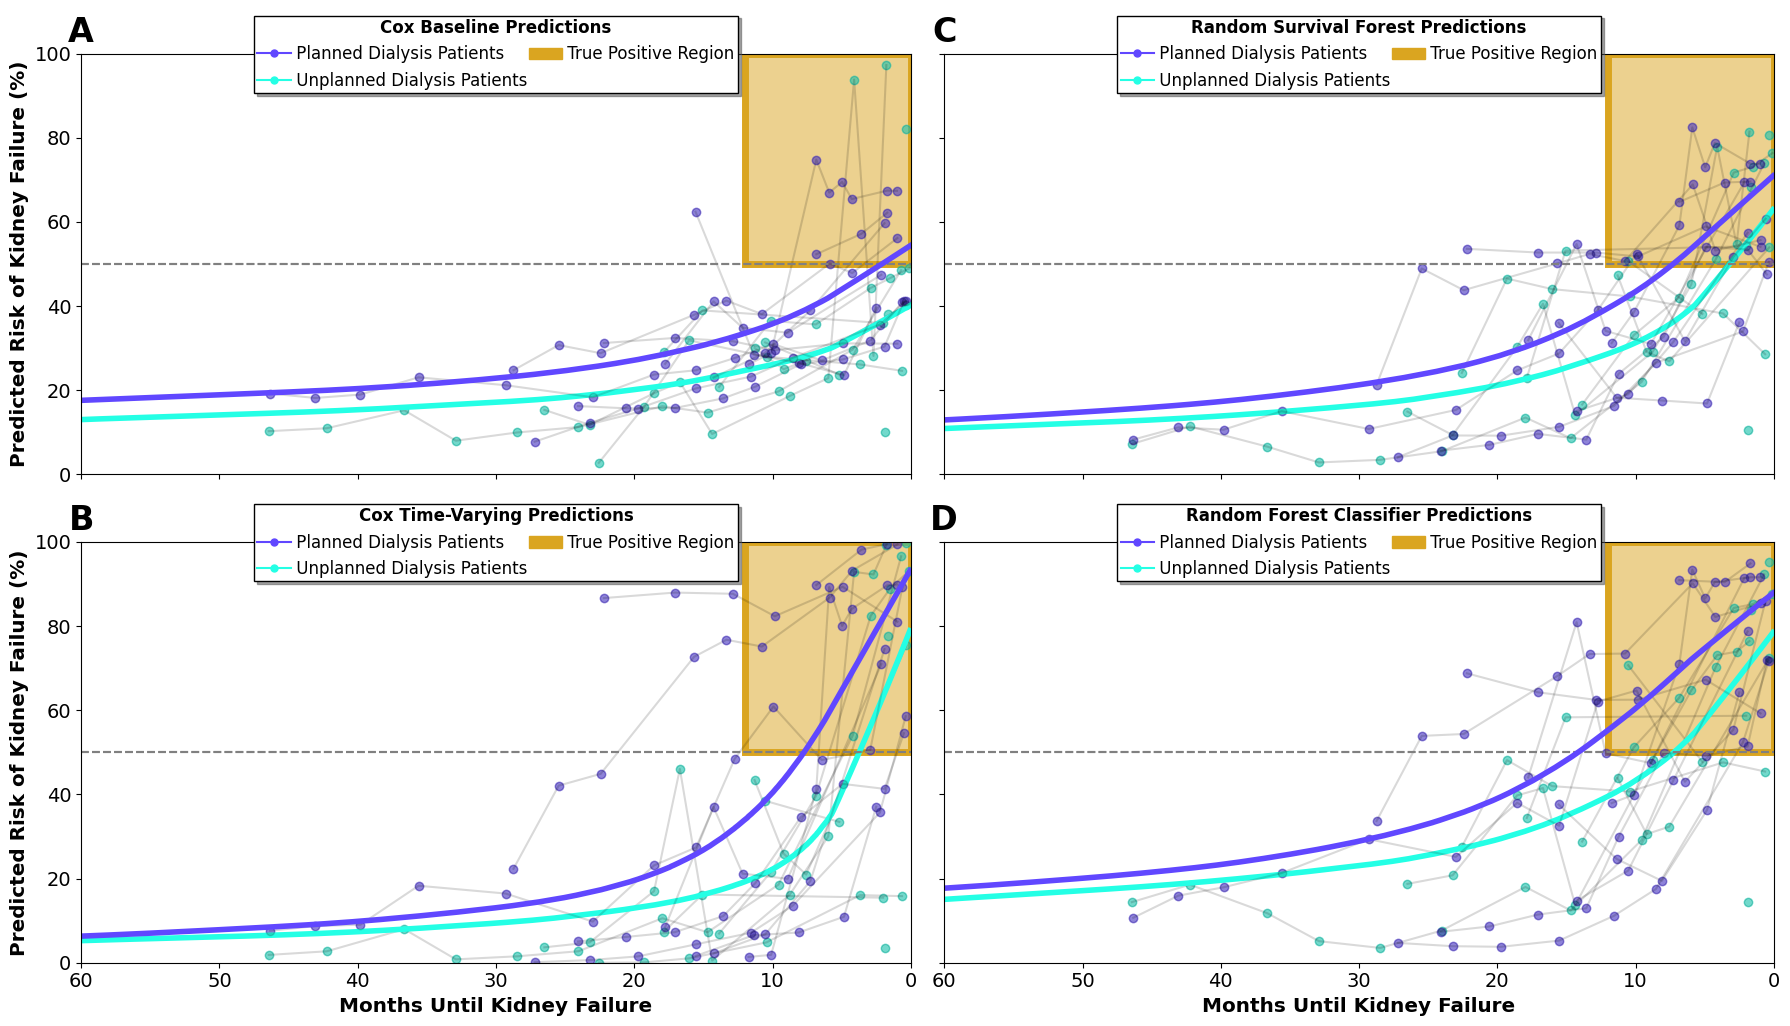

In [487]:
fig, plots = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(18, 10)

joined_scat_plot(results_by_time[1][0], 1, "BL COX", "P2(KF)", [samp1, samp2], [ud_sample, pd_sample], "Cox Baseline Predictions", letter="A", xlabel=False, ylabel=True, ax=plots[0][0])
joined_scat_plot(results_by_time[1][1], 1, "RSF", "P2(KF)", [samp1, samp2], [ud_sample, pd_sample], "Random Survival Forest Predictions", letter="C", xlabel=False, ylabel=False, ax=plots[0][1])
joined_scat_plot(results_by_time[1][2], 1, "TV COX", "P(KF)", [samp1, samp2], [ud_sample, pd_sample], "Cox Time-Varying Predictions", letter="B", xlabel=True, ylabel=True, ax=plots[1][0])
joined_scat_plot(results_by_time[1][1], 1, "RCF", "P(KF)", [samp1, samp2], [ud_sample, pd_sample], "Random Forest Classifier Predictions", letter="D", xlabel=True, ylabel=False, ax=plots[1][1])
plt.tight_layout(h_pad=3.5)

## KFRE

In [76]:
perfs = list()

for current_fold, (train_i, test_i) in enumerate(folds):
    x_train = df.reset_index(drop=True).loc[train_i]
    y_train = df.reset_index(drop=True)["labeldial24"].loc[train_i]
    x_test = df.reset_index(drop=True).loc[test_i]
    y_test = df.reset_index(drop=True)["labeldial24"].loc[test_i]

    ages = x_test.age.to_numpy()
    genders = x_test.gender.to_numpy()
    gfrs = x_test.egfr.to_numpy()
    acrs = x_test.spot_acr.to_numpy() / 0.113

    kfre_probs2 = flib.kfre_4v_nonNA(ages, genders, gfrs, acrs)[:,0]

    perfs.append(ulib.get_metrics(y_test, kfre_probs2))

perfs = pd.DataFrame(perfs, columns=["AUC-ROC", "AUC-PR", "PrRe70", "Brier"])
perfs

,AUC-ROC,AUC-PR,PrRe70,Brier
0,0.859555,0.883517,0.859345,0.193059
1,0.866144,0.888753,0.833490,0.184886
2,0.811533,0.838959,0.783217,0.204941
3,0.810464,0.838378,0.775065,0.203673
4,0.855033,0.878787,0.830366,0.194586


In [78]:
perfs.mean()

AUC-ROC    0.840546
AUC-PR     0.865679
PrRe70     0.816297
Brier      0.196229
dtype: float64

In [77]:
[ulib.stringify_bootstrap_ci(scipy.stats.bootstrap((perfs[col].to_numpy(), ), np.mean, method="percentile")) for col in metrics]

['(0.82, 0.86)', '(0.85, 0.88)', '(0.79, 0.84)', '(0.19, 0.2)']

# Cohort Statistics

## Table 1

In [302]:
pd.concat([
    df.drop_duplicates(subset="pt_id")[vs[-1] + ["measd_dbp", "creat", "bmi"]].mean(), 
    df.drop_duplicates(subset="pt_id")[vs[-1] + ["measd_dbp", "creat", "bmi"]].std()
], axis=1)

,0,1
diabetes,0.598056,0.490431
pmh_hyper,0.913093,0.281779
spot_acr,237.000629,252.543500
age,66.160332,14.554152
egfr,18.482472,6.247664
gender,0.371641,0.483381
alb,34.597484,4.959944
phos,1.366015,0.307397
calc,2.226552,0.152411
total_co2,24.032018,3.361020


In [301]:
df.drop_duplicates(subset="pt_id").spot_acr.describe()

count    1749.000000
mean      237.000629
std       252.543500
min         0.000000
25%        47.900000
50%       164.300000
75%       334.400000
max      2019.400000
Name: spot_acr, dtype: float64

In [309]:
drugs = pd.read_csv("../data/ottawa/drugs.csv")
gne = drugs.drop_duplicates(subset="pt_id")
gne = gne.loc[gne.pt_id.isin(set(df.pt_id))]

print(# ace inhibitor
gne.RAS_I_Final.value_counts())

print(# diuretic

gne.loc[(gne.Thiazide_final == 1) | (gne.Aldo_final == 1) | (gne.loop_final == 1)].shape)

0    868
1    771
Name: RAS_I_Final, dtype: int64
(1005, 6)


In [311]:
# percentages with respect to actual df size (im assuming 0s for the missing patients; im not even using this data)
print(771/1757)
print(1005/1757)

0.4388161639157655
0.5719977233921457


In [357]:
df.drop_duplicates(subset="pt_id", keep="last").labelo.value_counts()

1    770
2    427
3    336
0    216
Name: labelo, dtype: int64

In [358]:
df.drop_duplicates(subset="pt_id", keep="last").labelo.value_counts(normalize=True)

1    0.440252
2    0.244140
3    0.192110
0    0.123499
Name: labelo, dtype: float64

In [561]:
(df.drop_duplicates(subset="pt_id").sa_time / 30).describe()

count    1749.000000
mean       26.780999
std        22.685357
min         0.133333
25%         9.800000
50%        20.833333
75%        36.933333
max       131.200000
Name: sa_time, dtype: float64

In [45]:
nfups = ulib.get_common_key_values(results_by_time[0][0], "# Follow-Ups")
pd.DataFrame(nfups).describe()

,0
count,1749.000000
mean,6.742710
std,4.688965
min,1.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,33.000000


In [49]:
df.drop_duplicates(subset="pt_id").sa_time.describe()

count    1749.000000
mean      803.429960
std       680.560718
min         4.000000
25%       294.000000
50%       625.000000
75%      1108.000000
max      3936.000000
Name: sa_time, dtype: float64

In [53]:
# outcome rates
pd.concat([df.drop_duplicates(subset="pt_id", keep="last").patransf_where.value_counts(normalize=True), df.drop_duplicates(subset="pt_id", keep="last").patransf_where.value_counts()], axis=1)

,patransf_where,patransf_where
0,0.313894,549
4,0.232133,406
5,0.218982,383
3,0.153802,269
2,0.052030,91
6,0.026872,47
7,0.002287,4


In [54]:
# outcome rates
pd.concat([df.drop_duplicates(subset="pt_id", keep="last").cs_pt_alive.value_counts(normalize=True), df.drop_duplicates(subset="pt_id", keep="last").cs_pt_alive.value_counts()], axis=1)

,cs_pt_alive,cs_pt_alive
1,0.801601,1402
0,0.198399,347


# Some Analysis On Performance Results

## Performance vs. Lab Draw Type

In [430]:
len(set(df.loc[df.fup_date <= pd.to_datetime("01 Nov 2019")].pt_id))

1706

In [431]:
len(set(df.loc[df.fup_date > pd.to_datetime("01 Nov 2019")].pt_id))

209

In [432]:
len(set(df.loc[df.fup_date > pd.to_datetime("01 Nov 2019")].pt_id) & set(df.loc[df.fup_date <= pd.to_datetime("01 Nov 2019")].pt_id))

166